# Infection Spread Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.notebook import tqdm
import multiprocessing as mp
from collections import defaultdict
import itertools

from data import make_flights_df
from simulation import (
    simulate, 
    infection_stats, 
    make_time_to_infection_df
)
from graph import build_flights_graph

%matplotlib inline

In [2]:
%%time

flights_df = make_flights_df(path="data/2008.csv")

CPU times: user 15.4 s, sys: 1.02 s, total: 16.5 s
Wall time: 16.5 s


## Spread Speed

In [3]:
%%time

probas = [0.01, 0.05, 0.1, 0.5, 1.] * 10

with mp.Pool(mp.cpu_count()) as pool:
    simulations = pool.starmap(simulate, zip(itertools.repeat(flights_df), probas))

proba_simulations = defaultdict(list)
for proba, sim in zip(probas, simulations):
    proba_simulations[proba].append(sim)

CPU times: user 1.77 s, sys: 664 ms, total: 2.44 s
Wall time: 24min 4s


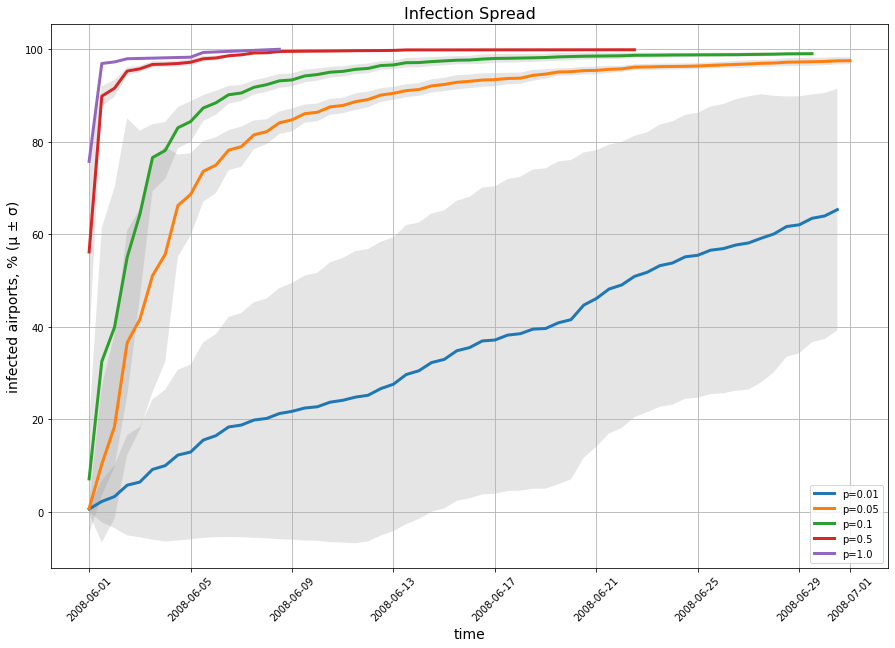

In [4]:
plt.figure(figsize=(15, 10))

for proba, simulations in proba_simulations.items():
    stats_df = infection_stats(simulations)
    xs = stats_df.index
    ys = stats_df.infected_mean * 100 / flights_df.Dest.nunique()
    deltas = stats_df.infected_std * 100 / flights_df.Dest.nunique()
    plt.plot(
        xs, ys,
        label=f'p={proba}',
        linewidth=3
    )
    plt.fill_between(
        xs, ys + deltas, ys - deltas, 
        facecolor='gray', 
        alpha=0.2
    )
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.grid()
plt.title('Infection Spread', fontsize=16)
plt.xlabel('time', fontsize=14)
plt.ylabel('infected airports, % (μ ± σ)', fontsize=14)
plt.show()

## Graph features and infection spread

### Time to infection

In [5]:
%%time

probas = [0.5] * 50

with mp.Pool(mp.cpu_count()) as pool:
    simulations = pool.starmap(simulate, zip(itertools.repeat(flights_df), probas))

tti_df = make_time_to_infection_df(simulations)

CPU times: user 1.83 s, sys: 669 ms, total: 2.5 s
Wall time: 24min 25s


### Graph features

In [6]:
G = build_flights_graph(flights_df)

Degree - the number of adjacent edges.

Clustering coefficient - a numeric measure of presence in a local highly connected cluster:

$$C_v=\frac{\textrm{# of triangles with }v}{\textrm{# of all possible traingles given the degree}}$$

Betweenness centrality - how cetral the node is in terms of the number of shortest paths connecting other nodes:

$$g(v)=\sum_{s\neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$

In [7]:
node_features = defaultdict(dict)

for node, value in nx.clustering(G).items():
    node_features[node]['cluster_coef'] = value

for node, value in dict(nx.degree(G)).items():
    node_features[node]['degree'] = value

for node, value in nx.betweenness_centrality(G).items():
    node_features[node]['betweenness'] = value

features_df = pd.DataFrame(data=list(node_features.values()), index=list(node_features.keys()))

### Correlations

In [8]:
airport_df = tti_df.join(features_df)

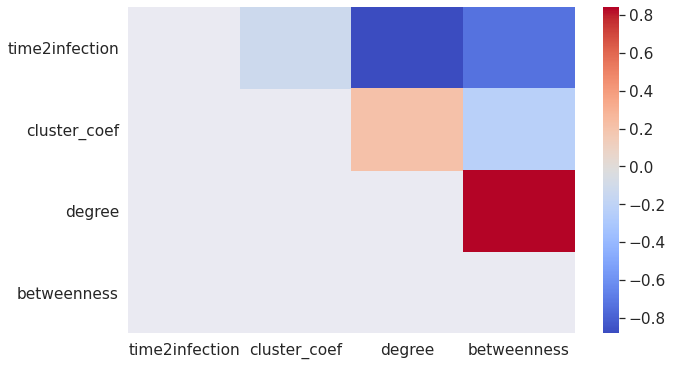

In [9]:
plt.figure(figsize=(10, 6))
corr = airport_df.corr(method='spearman')
sns.set(font_scale=1.4)
sns.heatmap(corr, cmap='coolwarm', mask=np.tril(corr))
plt.show()

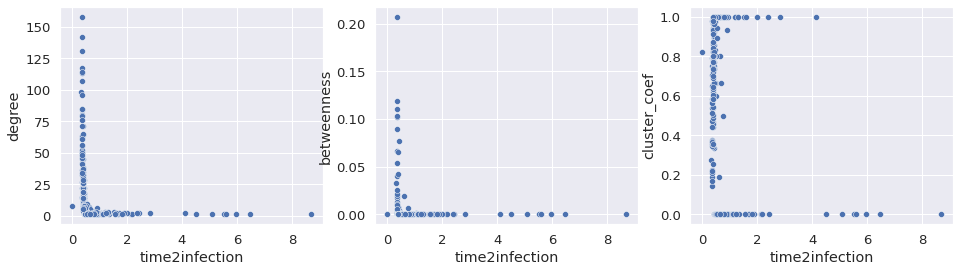

In [10]:
plt.figure(figsize=(16, 4))
sns.set(font_scale=1.2)

feature_cols = ['degree', 'betweenness', 'cluster_coef']

for i, col in enumerate(feature_cols, start=1):
    plt.subplot(1, len(feature_cols), i)
    sns.scatterplot(data=airport_df, x='time2infection', y=col)

plt.show()

### Comments

* The most correlated feature is **degree**: the more immediate neigbours an airport has, the faster it gets infected.
* Another strong predictor is **centrality betweenness**: the more shortest paths pass through the airport, the faster it gets infected.
* High **clustering coefficient** does not necessarily mean fast infection. Even though an airport is part of a triangle, the flights between the airport and its neigbours can be quite rare.

In [11]:
airport_df[(airport_df.cluster_coef == 1.0) & (airport_df.time2infection > 3)]

,time2infection,cluster_coef,degree,betweenness
airport,,,,
DLG,4.120758,1.0,2,0.0


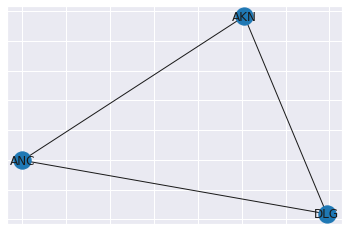

In [14]:
H = nx.ego_graph(G, n='DLG', radius=1)
nx.draw_networkx(H, with_labels=True)

In [15]:
airport_df.loc[list(G.neighbors('DLG'))]

,time2infection,cluster_coef,degree,betweenness
airport,,,,
AKN,2.818483,1.000000,2,0.000000
ANC,0.418717,0.335979,28,0.076825
